### Importing Libraries

In [1]:
import numpy as np
%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx
import neal
import csv
import os

In [2]:
def euclidean_distance(x1, y1, x2, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2) ** 0.5

def parse_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    node_coord_section = False
    node_matrix = []
    distance_matrix = None

    for line in lines:
        if line.startswith("NODE_COORD_SECTION"):
            node_coord_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_coord_section:
            node_info = line.split()
            node_id = int(node_info[0])
            # x_coord = int(float(node_info[1]))  # Convert to int
            # y_coord = int(float(node_info[2]))  # Convert to int
            x_coord = float(node_info[1])  # Convert to int
            y_coord = float(node_info[2])  # Convert to int

            node_matrix.append([node_id, x_coord, y_coord])

    node_matrix = np.array(node_matrix)

    # Calculate distance matrix (as in the previous version)
    num_nodes = node_matrix.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            x1, y1 = node_matrix[i, 1], node_matrix[i, 2]
            x2, y2 = node_matrix[j, 1], node_matrix[j, 2]
            distance_matrix[i, j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    return node_matrix, distance_matrix

In [3]:
def plot_city(cities, sol=None):
    n_city = len(cities)
    cities_dict = dict(cities)
    G = nx.Graph()
    for city in cities_dict:
        G.add_node(city)
        
    # draw path
    if sol:
        city_order = []
        for i in range(n_city):
            for j in range(n_city):
                if sol.array('c', (i, j)) == 1:
                    city_order.append(j)
        for i in range(n_city):
            city_index1 = city_order[i]
            city_index2 = city_order[(i+1) % n_city]
            G.add_edge(cities[city_index1][0], cities[city_index2][0])

    plt.figure(figsize=(3,3))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, cities_dict)
    plt.axis("off")
    plt.show()

def dist(i, j, cities):
    pos_i = cities[i][1]
    pos_j = cities[j][1]
    return np.sqrt((pos_i[0] - pos_j[0])**2 + (pos_i[1] - pos_j[1])**2)

In [4]:
def solve_for_instances(file_path, nodes_matrix, relaxation_parameter_start, relaxation_parameter_end, relaxation_parameter_step_size, instanceNumber=0, num_cities_in_a_instance=20):
    cities = [(i,(0,0)) for i in range(num_cities_in_a_instance)]
    n_mat = nodes_matrix.copy()
    for i in range(num_cities_in_a_instance):
        cities[i] = (str(n_mat[i][0]), (n_mat[i][1], n_mat[i][2]))
    plot_city(cities)
    print(cities)

    ## Prepare binary vector with bit (𝑖,𝑗) representing to visit 𝑗 city at time 𝑖
    n_city = len(cities)
    x = Array.create('c', (n_city, n_city), 'BINARY')
    # print(x)

    ## Constraint not to visit more than two cities at the same time.
    ## equation (6) implemented here
    ## time_const + city_const = H_a
    time_const = 0.0
    for i in range(n_city):
        # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
        time_const += Constraint((sum(x[i, j] for j in range(n_city)) - 1)**2, label="time{}".format(i))

    ## Constraint not to visit the same city more than twice.
    city_const = 0.0
    for j in range(n_city):
        city_const += Constraint((sum(x[i, j] for i in range(n_city)) - 1)**2, label="city{}".format(j))

    # print("time_const: ", time_const)
    # print("city_const: ", city_const)

    ## distance of route
    ## equation (5) implemented here
    distance = 0.0
    for i in range(n_city):
        for j in range(n_city):
            for k in range(n_city):
                d_ij = dist(i, j, cities)
                distance += d_ij * x[k, i] * x[(k+1)%n_city, j]  # sum(d_uv) in eq.5 i.e. H_b

    # print("distance: ", distance)

    ## Construct hamiltonian
    A = Placeholder("A")  # the relaxation parameter
    H = distance + A * (time_const + city_const)  # Eq (4)

    # print("Relaxation Parameter A: ", A)
    # print("Hamiltonian H: ", H)

    ## Compile model
    model = H.compile()

    ## Generate QUBO
    ## maybe we can add a loop to go through different relaxation parameter here
    feed_dict = {'A': 300.0}  # setting it to upper bound of the coordinate works!!!
    bqm = model.to_bqm(feed_dict=feed_dict)


    sa = neal.SimulatedAnnealingSampler()
    Pf_arr = []
    r_arr = []
    for r in range (relaxation_parameter_start, relaxation_parameter_end, relaxation_parameter_step_size):
        feed_dict = {'A': r}   
        bqm = model.to_bqm(feed_dict=feed_dict)
        sampleset = sa.sample(bqm, num_reads=128, num_sweeps=128)

        decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
        best_sample = min(decoded_samples, key=lambda x: x.energy)
        energy = best_sample.energy
        num_broken = len(best_sample.constraints(only_broken=True))
        infeasible_ctr = 0
        for i in range(128):
            if len(decoded_samples[i].constraints(only_broken=True)) > 0:
                infeasible_ctr += 1
        P_f = (128-infeasible_ctr)/128
        print(f"P_f for {feed_dict} is {P_f}")
        Pf_arr.append(P_f)
        r_arr.append(r)

    ## Define the filename for the plot
    result_plot_folder = "TestResultPlots"
    plot_base_filename = os.path.basename(file_path)
    result_filename = os.path.splitext(plot_base_filename)[0]
    if not os.path.exists(result_plot_folder):
        os.makedirs(result_plot_folder)

    plot_filename = f"{result_plot_folder}/{result_filename}_instance_{instanceNumber}_plot.png"

    ## Plot the graph
    plt.scatter(r_arr,Pf_arr)
    plt.xlabel("Relaxation Parameter")
    plt.ylabel("$P_f$")
    plt.title(f"File: {file_path}\nInstance: {instanceNumber}")

    ## Save the plot as a PNG image in the 'ResultPlots' folder
    plt.savefig(plot_filename)

    plt.close()  # Close the current figure to avoid it being shown by plt.show()

    return r_arr, Pf_arr

In [5]:
def processTsp(file_path, relaxation_parameter_start, relaxation_parameter_end, relaxation_parameter_step_size, num_cities_in_a_instance=30):
    nodes_matrix, distance_matrix = parse_tsp_file(file_path)

    num_nodes = nodes_matrix.shape[0]
    num_instances = (num_nodes + num_cities_in_a_instance - 1) // num_cities_in_a_instance

    for instanceNumber in range(num_instances):
        start_index = instanceNumber * num_cities_in_a_instance
        end_index = min((instanceNumber + 1) * num_cities_in_a_instance, num_nodes)
        instance_nodes_matrix = nodes_matrix[start_index:end_index]

        if len(instance_nodes_matrix) == 0:
            break  # No more nodes to process

        r_arr, Pf_arr = solve_for_instances(file_path, instance_nodes_matrix, relaxation_parameter_start, relaxation_parameter_end, relaxation_parameter_step_size, instanceNumber+1, len(instance_nodes_matrix))

        ## Save the result in a csvfile
        # Create a list of tuples (Relaxation Parameter A, Probability P_f)
        result_data = list(zip(r_arr, Pf_arr))

        # Define the filename for the CSV file
        results_folder = "TestResultsFolder"
        base_filename = os.path.basename(file_path)
        result_filename = os.path.splitext(base_filename)[0]
        csv_file = f"{results_folder}/{result_filename}_instance{instanceNumber+1}.csv"

        # Write the data to the CSV file
        with open(csv_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Relaxation Parameter A', 'Probability P_f'])
            writer.writerows(result_data)

        print(f"Results for instance {instanceNumber+1} saved to {csv_file}.")

In [6]:
def process_tsp_files_in_folder(folder_name, relaxation_parameter_start, relaxation_parameter_end, relaxation_parameter_step_size, num_cities_in_a_instance=30):
    if not os.path.exists(folder_name):
        raise ValueError(f"Folder '{folder_name}' does not exist.")

    files_in_folder = [file for file in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, file))]

    for file_name in files_in_folder:
        if file_name.endswith('.tsp'):
            file_path = os.path.join(folder_name, file_name)
            print(f"Processing file: {file_name}")
            processTsp(file_path, relaxation_parameter_start, relaxation_parameter_end, relaxation_parameter_step_size, num_cities_in_a_instance)
            print("----------------------------------------------------")

Processing file: eil51.tsp


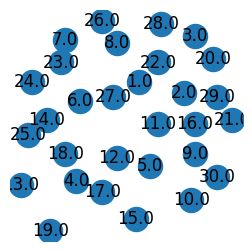

[('1.0', (37.0, 52.0)), ('2.0', (49.0, 49.0)), ('3.0', (52.0, 64.0)), ('4.0', (20.0, 26.0)), ('5.0', (40.0, 30.0)), ('6.0', (21.0, 47.0)), ('7.0', (17.0, 63.0)), ('8.0', (31.0, 62.0)), ('9.0', (52.0, 33.0)), ('10.0', (51.0, 21.0)), ('11.0', (42.0, 41.0)), ('12.0', (31.0, 32.0)), ('13.0', (5.0, 25.0)), ('14.0', (12.0, 42.0)), ('15.0', (36.0, 16.0)), ('16.0', (52.0, 41.0)), ('17.0', (27.0, 23.0)), ('18.0', (17.0, 33.0)), ('19.0', (13.0, 13.0)), ('20.0', (57.0, 58.0)), ('21.0', (62.0, 42.0)), ('22.0', (42.0, 57.0)), ('23.0', (16.0, 57.0)), ('24.0', (8.0, 52.0)), ('25.0', (7.0, 38.0)), ('26.0', (27.0, 68.0)), ('27.0', (30.0, 48.0)), ('28.0', (43.0, 67.0)), ('29.0', (58.0, 48.0)), ('30.0', (58.0, 27.0))]
P_f for {'A': 20} is 0.0
P_f for {'A': 22} is 0.0078125
P_f for {'A': 24} is 0.0078125
P_f for {'A': 26} is 0.1015625
P_f for {'A': 28} is 0.0546875
P_f for {'A': 30} is 0.171875
P_f for {'A': 32} is 0.34375
P_f for {'A': 34} is 0.421875
P_f for {'A': 36} is 0.5625
P_f for {'A': 38} is 0.76

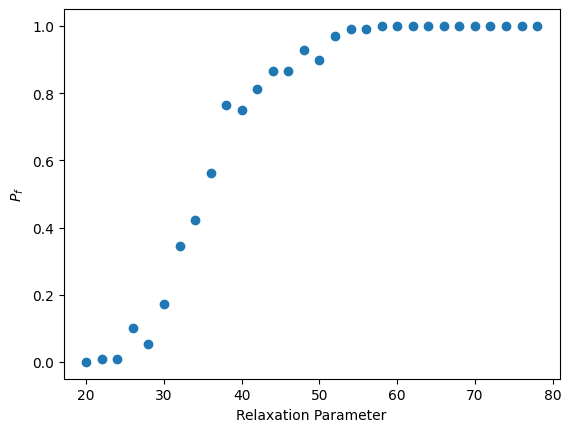

Results for instance 1 saved to TestResultsFolder/eil51_instance1.csv.


<Figure size 640x480 with 0 Axes>

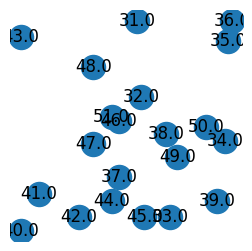

[('31.0', (37.0, 69.0)), ('32.0', (38.0, 46.0)), ('33.0', (46.0, 10.0)), ('34.0', (61.0, 33.0)), ('35.0', (62.0, 63.0)), ('36.0', (63.0, 69.0)), ('37.0', (32.0, 22.0)), ('38.0', (45.0, 35.0)), ('39.0', (59.0, 15.0)), ('40.0', (5.0, 6.0)), ('41.0', (10.0, 17.0)), ('42.0', (21.0, 10.0)), ('43.0', (5.0, 64.0)), ('44.0', (30.0, 15.0)), ('45.0', (39.0, 10.0)), ('46.0', (32.0, 39.0)), ('47.0', (25.0, 32.0)), ('48.0', (25.0, 55.0)), ('49.0', (48.0, 28.0)), ('50.0', (56.0, 37.0)), ('51.0', (30.0, 40.0))]
P_f for {'A': 20} is 0.0
P_f for {'A': 22} is 0.0
P_f for {'A': 24} is 0.0
P_f for {'A': 26} is 0.0
P_f for {'A': 28} is 0.0
P_f for {'A': 30} is 0.0078125
P_f for {'A': 32} is 0.015625
P_f for {'A': 34} is 0.0625
P_f for {'A': 36} is 0.0625
P_f for {'A': 38} is 0.109375
P_f for {'A': 40} is 0.203125
P_f for {'A': 42} is 0.265625
P_f for {'A': 44} is 0.3125
P_f for {'A': 46} is 0.4140625
P_f for {'A': 48} is 0.5703125
P_f for {'A': 50} is 0.6484375
P_f for {'A': 52} is 0.6875
P_f for {'A': 54}

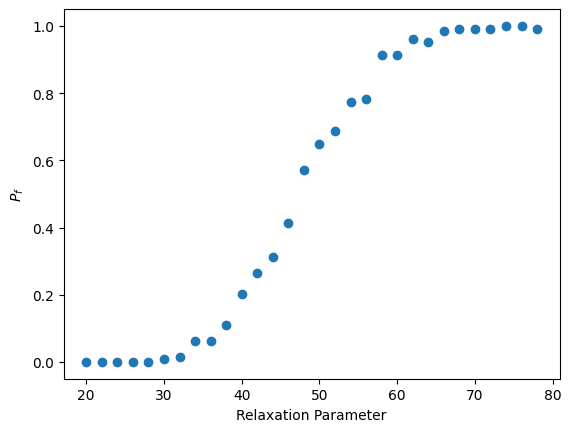

Results for instance 2 saved to TestResultsFolder/eil51_instance2.csv.
----------------------------------------------------
Processing file: eil76.tsp


<Figure size 640x480 with 0 Axes>

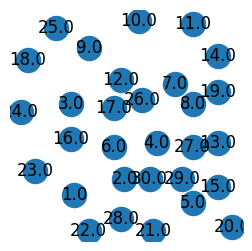

[('1.0', (22.0, 22.0)), ('2.0', (36.0, 26.0)), ('3.0', (21.0, 45.0)), ('4.0', (45.0, 35.0)), ('5.0', (55.0, 20.0)), ('6.0', (33.0, 34.0)), ('7.0', (50.0, 50.0)), ('8.0', (55.0, 45.0)), ('9.0', (26.0, 59.0)), ('10.0', (40.0, 66.0)), ('11.0', (55.0, 65.0)), ('12.0', (35.0, 51.0)), ('13.0', (62.0, 35.0)), ('14.0', (62.0, 57.0)), ('15.0', (62.0, 24.0)), ('16.0', (21.0, 36.0)), ('17.0', (33.0, 44.0)), ('18.0', (9.0, 56.0)), ('19.0', (62.0, 48.0)), ('20.0', (66.0, 14.0)), ('21.0', (44.0, 13.0)), ('22.0', (26.0, 13.0)), ('23.0', (11.0, 28.0)), ('24.0', (7.0, 43.0)), ('25.0', (17.0, 64.0)), ('26.0', (41.0, 46.0)), ('27.0', (55.0, 34.0)), ('28.0', (35.0, 16.0)), ('29.0', (52.0, 26.0)), ('30.0', (43.0, 26.0))]
P_f for {'A': 20} is 0.0
P_f for {'A': 22} is 0.0
P_f for {'A': 24} is 0.015625
P_f for {'A': 26} is 0.0390625
P_f for {'A': 28} is 0.0625
P_f for {'A': 30} is 0.1171875
P_f for {'A': 32} is 0.234375
P_f for {'A': 34} is 0.3046875
P_f for {'A': 36} is 0.5
P_f for {'A': 38} is 0.59375
P_f f

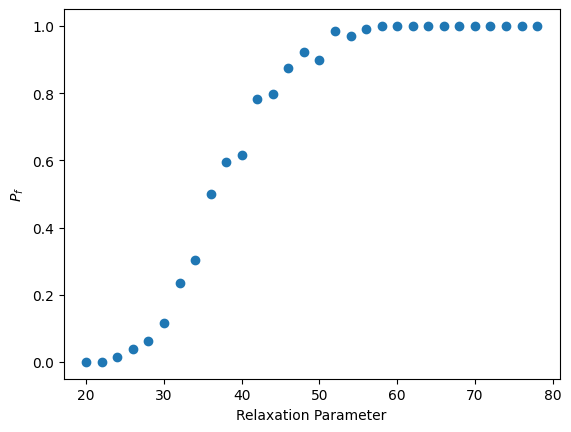

Results for instance 1 saved to TestResultsFolder/eil76_instance1.csv.


<Figure size 640x480 with 0 Axes>

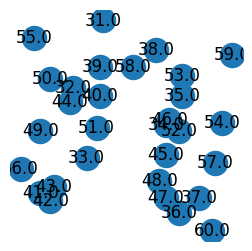

[('31.0', (31.0, 76.0)), ('32.0', (22.0, 53.0)), ('33.0', (26.0, 29.0)), ('34.0', (50.0, 40.0)), ('35.0', (55.0, 50.0)), ('36.0', (54.0, 10.0)), ('37.0', (60.0, 15.0)), ('38.0', (47.0, 66.0)), ('39.0', (30.0, 60.0)), ('40.0', (30.0, 50.0)), ('41.0', (12.0, 17.0)), ('42.0', (15.0, 14.0)), ('43.0', (16.0, 19.0)), ('44.0', (21.0, 48.0)), ('45.0', (50.0, 30.0)), ('46.0', (51.0, 42.0)), ('47.0', (50.0, 15.0)), ('48.0', (48.0, 21.0)), ('49.0', (12.0, 38.0)), ('50.0', (15.0, 56.0)), ('51.0', (29.0, 39.0)), ('52.0', (54.0, 38.0)), ('53.0', (55.0, 57.0)), ('54.0', (67.0, 41.0)), ('55.0', (10.0, 70.0)), ('56.0', (6.0, 25.0)), ('57.0', (65.0, 27.0)), ('58.0', (40.0, 60.0)), ('59.0', (70.0, 64.0)), ('60.0', (64.0, 4.0))]
P_f for {'A': 20} is 0.0
P_f for {'A': 22} is 0.0
P_f for {'A': 24} is 0.0
P_f for {'A': 26} is 0.0
P_f for {'A': 28} is 0.0078125
P_f for {'A': 30} is 0.0
P_f for {'A': 32} is 0.0625
P_f for {'A': 34} is 0.09375
P_f for {'A': 36} is 0.125
P_f for {'A': 38} is 0.171875
P_f for {'A

In [7]:
folder_name = "TestTSPFolder"
relaxation_parameter_start = 20
relaxation_parameter_end = 80
relaxation_parameter_step_size = 2
process_tsp_files_in_folder(folder_name, relaxation_parameter_start, relaxation_parameter_end, relaxation_parameter_step_size, num_cities_in_a_instance=30)